In [4]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime
from scipy import stats as scipystats
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions
from analysis.plots.placecells.utils import get_figure_size
from analysis.plots.placecells.draw import draw_occupancy, draw_place_field, draw_place_firing
from analysis.models.analytics import place_field_2D

from functools import reduce # only in Python 3

import nbimporter
from Utils import get_metrics, get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [11]:
color_a, color_b, color_c, color_d, color_e = get_colors()

where = '/home/andrey/storage2/andrey/data/processed'
animals = ['003281', '003282', '003908', '003909']  # all
#animals = ['003282']  # all

sessions_list = list(get_sessions_list(where, animals, 'SHIFT periodic +dark'))

# temprarily filter out unprocessed sessions
#date_before = datetime.strptime('2020-06-16_15-35-14', '%Y-%m-%d_%H-%M-%S')
sessions_list = [x for x in sessions_list if datetime.strptime(x[1], '%Y-%m-%d_%H-%M-%S') < date_before]

sessions_list

[['003281', '2019-11-21_13-44-47', 'SHIFT periodic +dark'],
 ['003281', '2019-11-21_22-51-03', 'SHIFT periodic +dark'],
 ['003282', '2019-11-20_15-58-39', 'SHIFT periodic +dark'],
 ['003282', '2019-11-21_09-44-05', 'SHIFT periodic +dark'],
 ['003282', '2019-11-21_21-58-48', 'SHIFT periodic +dark'],
 ['003282', '2019-11-24_20-06-11', 'SHIFT periodic +dark'],
 ['003282', '2019-11-26_09-48-18', 'SHIFT periodic +dark'],
 ['003282', '2019-11-27_17-12-57', 'SHIFT periodic +dark'],
 ['003282', '2019-11-28_13-31-13', 'SHIFT periodic +dark'],
 ['003282', '2019-11-29_14-16-57', 'SHIFT periodic +dark'],
 ['003282', '2019-12-02_17-51-29', 'SHIFT periodic +dark'],
 ['003908', '2020-03-24_21-57-00', 'SHIFT periodic +dark'],
 ['003908', '2020-03-24_10-32-01', 'SHIFT periodic +dark'],
 ['003908', '2020-03-23_17-37-17', 'SHIFT periodic +dark'],
 ['003908', '2020-04-09_16-08-17', 'SHIFT periodic +dark'],
 ['003908', '2020-05-03_17-42-23', 'SHIFT periodic +dark'],
 ['003908', '2020-05-04_22-29-15', 'SHIF

In [12]:
source = '/home/andrey/storage2/andrey/data/processed'
assets = '/home/andrey/storage2/andrey/data/projects/24_shift/assets'
reports_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/reporting'

# many sessions detected above
sessions = sessions_list

# or a single session
# sessions = [
#     ['003282', '2019-11-06_22-36-07'],
#     ['003282', '2019-11-18_10-35-43'],
# ]

data_l, data_ra, data_rb, data_app, data_dis = get_metrics(source, sessions)
data_d, data_ra_d, data_rb_d, data_app_d, data_dis_d = get_metrics(source, sessions, nA='Ad', nB='Bd')
data_full_l = get_metrics(source, sessions, exclude_locations=False)[0]
data_full_d = get_metrics(source, sessions, exclude_locations=False, nA='Ad', nB='Bd')[0]

PF match found for 336 fields, 236 fields remapped
PF match found for 330 fields, 234 fields remapped
PF match found for 336 fields, 236 fields remapped
PF match found for 330 fields, 234 fields remapped


# Filters

## Single place fields

In [13]:
# only single place fields
idxs_fn = np.where((data_l[:, 9] == 1) & (data_l[:, 10] == 1))[0]

## Bad fields

- information content > 0.2
- firing rate > 2Hz
- isolation distance > 15

In [14]:
# sic > 0.2 only
idxs_ic_l = np.where((data_l[:, 7] > 0.2) & (data_l[:, 8] > 0.2))[0]
idxs_ic_d = np.where((data_d[:, 7] > 0.2) & (data_d[:, 8] > 0.2))[0]

# firing rate > 2 Hz
idxs_fr_l = np.where((data_l[:, 11] > 2) & (data_l[:, 12] > 2))[0]
idxs_fr_d = np.where((data_d[:, 11] > 2) & (data_d[:, 12] > 2))[0]

# isolation distance > 15
idxs_id_l = np.where((data_l[:, 18] > 15))[0]
idxs_id_d = np.where((data_d[:, 18] > 15))[0]

## Split in 3 groups of shifts

In [15]:
delta = 0.075

# no shift: 0 +-0.75
idxs_0 = np.where((data_l[:, 6] > 0 - delta) & (data_l[:, 6] < 0 + delta))[0]

# medium shift: +0.15 +-0.75
idxs_15 = np.where((data_l[:, 6] > -0.15 - delta) & (data_l[:, 6] < -0.15 + delta))[0]

# full arena shift: +0.3 +-0.75
idxs_30 = np.where((data_l[:, 6] > -0.3 - delta) & (data_l[:, 6] < -0.3 + delta))[0]

## Select fields

In [16]:
# FIXME show that not a single cell falls into 0 shift category
no_outsiders_l = np.where((data_l[:, 6] > -0.2) & (data_l[:, 6] < 0.5))[0]
no_outsiders_d = np.where((data_d[:, 6] > -0.2) & (data_d[:, 6] < 0.5))[0]

# filter out all bad fields
idxs_l = reduce(np.intersect1d, [idxs_ic_l, idxs_fr_l, idxs_id_l, no_outsiders_l])
idxs_d = reduce(np.intersect1d, [idxs_ic_d, idxs_fr_d, idxs_id_d, no_outsiders_d])

# filter out all bad fields + leave only 1-1 fields
#idxs = reduce(np.intersect1d, [idxs_ic, idxs_fr, idxs_id, idxs_fn])

print("Number of fields in light: %d, dark: %s" % (len(idxs_l), len(idxs_d)))

Number of fields in light: 144, dark: 107


# ANALYSIS

## example fields

In [9]:
def spiking_plot(pos, traj_idxs, spk_idxs, inf, spa, sel, sic, coh):
    ax = fig.add_subplot(pos)
    ax.set_ylabel('Longitude, m')
    ax.grid(True)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.scatter(trajectory[traj_idxs][:, 1], trajectory[traj_idxs][:, 2], alpha=0.05, color='#B4B8AB')
    ax.scatter(trajectory[spk_idxs][:, 1], trajectory[spk_idxs][:, 2], color=color_a)
    ax.text(limits[1] - 0.55, limits[3] - 0.1, 'spa=%.2f' % spa, fontsize=14)
    ax.text(limits[1] - 0.55, limits[3] - 0.25, 'sic=%.2f' % sic, fontsize=14)
    
    # VR scene schematic
    img = plt.imread(os.path.join(assets, "arena_line.png"))
    ax.imshow(img, extent=[limits[0] + 0.05, limits[0] + 0.25, limits[2] + 0.05, limits[3] - 0.05])
    return ax

def field_plot(pos, pf, vmax):
    axA = fig.add_subplot(pos)
    axA.set_xlabel('Latitude, m')
    axA.set_ylabel('Longitude, m')
    axA.grid(True)
    axA.set_xlim(limits[0], limits[1])
    axA.set_ylim(limits[2], limits[3])
    posPFA = axA.imshow(pf.T, cmap='jet', origin='lower', extent=extent, vmax=vmax)

    # VR scene schematic
    img = plt.imread(os.path.join(assets, "arena_line.png"))
    axA.imshow(img, extent=[limits[0] + 0.05, limits[0] + 0.25, limits[2] + 0.05, limits[3] - 0.05])
    return axA


# put showcase units here
selection = [
    "003282_2019-11-21_21-58-48_7_2",  # stable
    "003282_2019-11-27_17-12-57_7_9",  # stable
    "003282_2019-11-29_14-16-57_5_8",  # stable
    "003281_2019-11-21_13-44-47_4_2",  # stable 0 shift
    "003282_2019-12-02_17-51-29_5_8",  # turns off
    "003282_2019-11-21_09-44-05_7_11", # turns off
    "003282_2019-11-21_09-44-05_3_6",  # remapping
]

selected_units = []
for line in selection:
    data = line.split('_')
    selected_units.append([
        data[0], data[1] + '_' + data[2], data[3], data[4]
    ])
    
dest_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/zSHOWCASE/dark'

for i, (animal, session_id, electrode, unit) in enumerate(selected_units):
    sessionpath = os.path.join(source, animal, session_id)
    h5file = os.path.join(sessionpath, 'all.h5')
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])

    conditions = ['A', 'B', 'Ad', 'Bd']
    spec2 = gridspec.GridSpec(ncols=len(conditions), nrows=2)
    fig = figure(figsize=(12, 9))
    limits = get_figure_size(trajectory[:, 1:3], border=0.05)
    limits = [-0.9, 0.4, limits[2], limits[3]]

    # first compute maximum peak firing rate to normalize field plots
    fr_all = []
    for j, cond in enumerate(conditions):
        with h5py.File(h5file, 'r') as f:
            unit_group = f['units']['%s_%s' % (electrode, unit)]
            fr_all.append(np.array(unit_group[cond+'_place_field']).max())
                
    for j, cond in enumerate(conditions):
        # reading data
        with h5py.File(h5file, 'r') as f:

            trajectory = np.array(f['animal_trajectory'])
            unit_groups = [x for x in f['units']]

            unit_group = f['units']['%s_%s' % (electrode, unit)]

            pos_firing = np.array(unit_group['trajectory_indexes'])

            mean_firing_rate = unit_group.attrs['mean_firing_rate'][0]
            burst_index = unit_group.attrs['burst_index'][0]
            isolation_distance = unit_group.attrs['isolation_distance'][0]
            traj_indexes = np.array(f[cond+'_indexes'])
            pf = np.array(unit_group[cond+'_place_field'])

            inf = unit_group[cond+'_place_field'].attrs['information']
            spa = unit_group[cond+'_place_field'].attrs['sparsity']
            sel = unit_group[cond+'_place_field'].attrs['selectivity']
            sic = unit_group[cond+'_place_field'].attrs['information_content']
            coh = unit_group[cond+'_place_field'].attrs['spatial_coherence']

            fmap = np.array(unit_group[cond+'_firing'])
            fields = np.array(unit_group[cond+'_fields'])
            COM = np.array(unit_group[cond+'_fields_COMs']) if cond+'_fields_COMs' in unit_group else None
            extent = np.array(unit_group.attrs['xy_range'])

        vmax = np.array(fr_all).max()
        
        # spiking + trajectories
        ax1 = spiking_plot(spec2[0, j], traj_indexes, np.intersect1d(pos_firing, traj_indexes), inf, spa, sel, sic, coh)
        if j == 1:
            labels = [item.get_text() for item in ax1.get_xticklabels()]
            empty_string_labels = ['']*len(labels)
            ax1.set_yticklabels(empty_string_labels)

        # place fields
        ax2 = field_plot(spec2[1, j], pf, vmax)
        if j == 1:
            labels = [item.get_text() for item in ax2.get_xticklabels()]
            empty_string_labels = ['']*len(labels)
            ax2.set_yticklabels(empty_string_labels)
    
    fig.tight_layout()
    filename = "%s_%s_%s_%s.png" % (animal, session_id, electrode, unit)
    fig.savefig(os.path.join(os.path.join(dest_folder), filename))
    
    plt.close(fig)
    plt.clf()

## Less number of fields in dark FIXME (wrong there is small # of fields)

In [36]:
delta = 0.1

num_per_session = []
for animal, session_id in sessions_list:
    num_l, num_d = 0, 0
    
    for i in idxs_l:
        if data_full_l[i][1] == session_id:
            num_l += 1

    for i in idxs_d:
        if data_full_d[i][1] == session_id:
            num_d += 1
            
    num_per_session.append([num_l, num_d])
    
num_per_session = np.array(num_per_session)

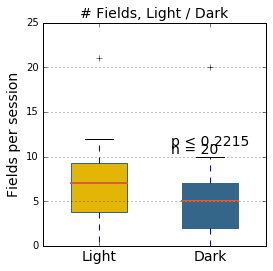

In [37]:
st, pval = scipystats.ttest_ind(num_per_session[:, 0], num_per_session[:, 1])

medianprops = dict(linestyle='-', linewidth=2, color=color_b)
boxprops = dict(linestyle='-', linewidth=1, color=color_a)

fig = figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.set_title('# Fields, Light / Dark', fontsize=14)
bplot = ax.boxplot([num_per_session[:, 0], num_per_session[:, 1]], widths=0.5, patch_artist=True, medianprops=medianprops, boxprops=boxprops)
ax.set_xticklabels(['Light', 'Dark'], fontsize=14)
ax.set_ylabel('Fields per session', fontsize=14)
ax.text(1.65, 11.3, 'p < %.4f' % pval, fontsize=14)
ax.text(1.65, 10.3, 'n = %d' % len(num_per_session), fontsize=14)


# patching colors
colors = [color_d, color_a]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
ax.yaxis.grid(True)

filename = "fields_boxplot_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Where did the fields go? Look at shift histogram

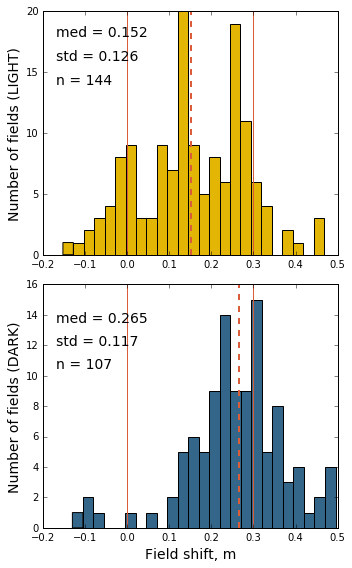

In [24]:
# histogram of COM shifts
fig = figure(figsize=(5, 8))

data = data_l[idxs_l][:, 6]
med = np.median(data)
std = np.std(data)
y_max = np.histogram(data, 25)[0].max()

ax = fig.add_subplot(211)
ax.set_xlim(-0.2, 0.5)
ax.set_ylabel('Number of fields (LIGHT)', fontsize=14)
ax.hist(data, 25, color=color_d)  # interesting 3-modal distribution? 
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.axvline(np.median(data), color=color_b, lw=2, ls='--')
ax.text(-0.17, 0.9 * y_max, 'med = %.3f' % med, fontsize=14)
ax.text(-0.17, 0.8 * y_max, 'std = %.3f' % std, fontsize=14)
ax.text(-0.17, 0.7 * y_max, 'n = %d' % len(data), fontsize=14)


data = data_d[idxs_d][:, 6]
med = np.median(data)
std = np.std(data)
y_max = np.histogram(data, 25)[0].max()

ax = fig.add_subplot(212)
ax.set_xlim(-0.2, 0.5)
ax.set_xlabel('Field shift, m', fontsize=14)
ax.set_ylabel('Number of fields (DARK)', fontsize=14)
ax.hist(data, 25, color=color_a)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.axvline(np.median(data), lw=2, ls='--', color=color_b)
ax.text(-0.17, 0.9 * y_max, 'med = %.3f' % med, fontsize=14)
ax.text(-0.17, 0.8 * y_max, 'std = %.3f' % std, fontsize=14)
ax.text(-0.17, 0.7 * y_max, 'n = %d' % len(data), fontsize=14)


fig.tight_layout()
filename = "vSHIFT_histogram_all_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

# test if normal
#k2, p = stats.normaltest(data_l[idxs][:, 6])

## More VR fields in the middle in light. More uniform in dark.

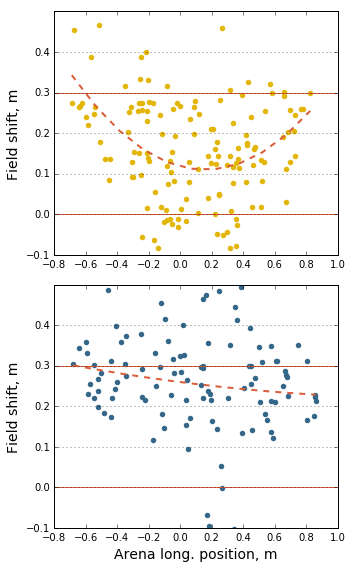

In [26]:
fig = figure(figsize=(5, 8))

# ------- in light distribution ---------

ax = fig.add_subplot(211)
ax.set_ylim(-0.1, 0.5)
#ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('Field shift, m', fontsize=14)
ax.scatter(data_l[idxs_l][:, 15], data_l[idxs_l][:, 6], color=color_d)
ax.axhline(0.3, color=color_b)
ax.axhline(0.0, color=color_b)
ax.yaxis.grid(True)

b_x = np.array(data_l[idxs_l][:, 15], dtype=float)
b_y = np.array(data_l[idxs_l][:, 6], dtype=float)
a, b, c = np.polyfit(b_x, b_y, 2)
y_min = data_l[idxs_l][:, 15].min()
y_max = data_l[idxs_l][:, 15].max()
x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]
ax.plot(x_space, y_space, lw=2, ls='--', color=color_b)

# ------- in dark distribution ---------

ax = fig.add_subplot(212)
ax.set_ylim(-0.1, 0.5)
ax.set_ylabel('Field shift, m', fontsize=14)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.scatter(data_d[idxs_d][:, 15], data_d[idxs_d][:, 6], color=color_a)
ax.axhline(0.3, color=color_b)
ax.axhline(0.0, color=color_b)
ax.yaxis.grid(True)

b_x = np.array(data_d[idxs_d][:, 15], dtype=float)
b_y = np.array(data_d[idxs_d][:, 6], dtype=float)
a, b, c = np.polyfit(b_x, b_y, 2)
y_min = data_d[idxs_d][:, 15].min()
y_max = data_d[idxs_d][:, 15].max()
x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]
ax.plot(x_space, y_space, lw=2, ls='--', color=color_b)

fig.tight_layout()
filename = "vSHIFT_field_arena_distribution_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Why there are less fields? Is there remapping or? Find field pairs that match in Light / Dark

In [27]:
"""
field_matches = [
    [ 
        # match_Al_to_Ad
        [field_Al_id, field_Ad_id, intersection_rel, [field_Al_COM_y, field_Ad_COM_y]], 
        
        # match_Bl_to_Bd
        [field_Bl_id, field_Bd_id, intersection_rel, [field_Bl_COM_y, field_Bd_COM_y]]
    ],
    ...
]
"""


field_matches = []
FRmin = 1.

# selecting all the field pairs from light condition
for i, field_pair_AB_stats in enumerate(data_l):
    
    # ------------- reading field data ---------------
    
    sessionpath = os.path.join(source, data_full_l[i][0], data_full_l[i][1])
    h5file = os.path.join(sessionpath, 'all.h5')
    
    with h5py.File(h5file, 'r') as f:
        electrode = field_pair_AB_stats[0]
        unit = field_pair_AB_stats[1]

        unit_group = f['units']['%d_%d' % (electrode, unit)]

        fieldsAl = np.array(unit_group['A_fields'])
        fieldsBl = np.array(unit_group['B_fields'])
        fieldsAd = np.array(unit_group['Ad_fields'])
        fieldsBd = np.array(unit_group['Bd_fields'])

        fieldsAlCOMs = np.array(unit_group['A_fields_COMs']) if 'A_fields_COMs' in unit_group else None
        fieldsBlCOMs = np.array(unit_group['B_fields_COMs']) if 'B_fields_COMs' in unit_group else None
        fieldsAdCOMs = np.array(unit_group['Ad_fields_COMs']) if 'Ad_fields_COMs' in unit_group else None
        fieldsBdCOMs = np.array(unit_group['Bd_fields_COMs']) if 'Bd_fields_COMs' in unit_group else None
        
        xy_range = np.array(unit_group.attrs['xy_range'])

    # -------- get field in condition A light and overlap with A dark ----
    
    match_Al_to_Ad = []
    match_Bl_to_Bd = []
    field_Al_id = field_pair_AB_stats[2]
    field_Bl_id = field_pair_AB_stats[3]
    
    intersection_size = 0
    for field_Ad_id in [y for y in np.unique(fieldsAd) if not y == 0]:

        # compute overlap +0
        fAl_idxs = np.where(np.flipud(fieldsAl.T).flatten() == field_Al_id)[0]
        fAd_idxs = np.where(np.flipud(fieldsAd.T).flatten() == field_Ad_id)[0]
        intersection_0 = np.intersect1d(fAl_idxs, fAd_idxs)
        intersection_rel = len(intersection_0) / ( (len(fAl_idxs) + len(fAd_idxs)) / 2 )

        peak_FRad = fieldsAdCOMs[fieldsAdCOMs[:, 0] == field_Ad_id][0][3] if fieldsAdCOMs is not None else 0
        
        # exclude fields with no overlap or low firing
        if intersection_rel > intersection_size and peak_FRad > FRmin:
            COMs = [
                fieldsAlCOMs[fieldsAlCOMs[:, 0] == field_Al_id][0][2], # light
                fieldsAdCOMs[fieldsAdCOMs[:, 0] == field_Ad_id][0][2]  # dark
            ]            
            match_Al_to_Ad = [field_Al_id, field_Ad_id, intersection_rel, COMs]
            intersection_size = intersection_rel

    # -------- get field in condition B light and overlap with B dark ----
            
    intersection_size = 0
    for field_Bd_id in [y for y in np.unique(fieldsBd) if not y == 0]:

        # compute overlap +0
        fBl_idxs = np.where(np.flipud(fieldsBl.T).flatten() == field_Bl_id)[0]
        fBd_idxs = np.where(np.flipud(fieldsBd.T).flatten() == field_Bd_id)[0]
        intersection_0 = np.intersect1d(fBl_idxs, fBd_idxs)
        intersection_rel = len(intersection_0) / ( (len(fBl_idxs) + len(fBd_idxs)) / 2 )
        
        peak_FRbd = fieldsBdCOMs[fieldsBdCOMs[:, 0] == field_Bd_id][0][3] if fieldsBdCOMs is not None else 0

        # exclude fields with no overlap or low firing
        if intersection_rel > intersection_size and peak_FRbd > FRmin:
            COMs = [
                fieldsBlCOMs[fieldsBlCOMs[:, 0] == field_Bl_id][0][2], # light
                fieldsBdCOMs[fieldsBdCOMs[:, 0] == field_Bd_id][0][2]  # dark
            ]            
            match_Bl_to_Bd = [field_Bl_id, field_Bd_id, intersection_rel, COMs]
            intersection_size = intersection_rel


    field_matches.append([match_Al_to_Ad, match_Bl_to_Bd])

In [28]:
both_match = []  # indexes of units with fully matched fields
only_one = []    # indexes of units with half-matched fields
full_remap = []  # indexes of units with no match

for i, row in enumerate(field_matches):
    if len(row[0]) > 0 and len(row[1]) > 0:
        both_match.append(i)
        continue

    if len(row[0]) == 0 and len(row[1]) == 0:
        full_remap.append(i)
        continue
        
    only_one.append(i)

idxs_both_match = np.array(both_match)
idxs_only_one = np.array(only_one)
idxs_full_remap = np.array(full_remap)

len(both_match), len(only_one), len(full_remap)

(179, 75, 82)

In [29]:
# indexes for STABLE fields
idxs_bm = np.intersect1d(idxs_both_match, idxs_l)

# indexes for all UNSTABLE fields
idxs_nm = np.intersect1d(np.concatenate([idxs_full_remap, idxs_only_one]), idxs_l)

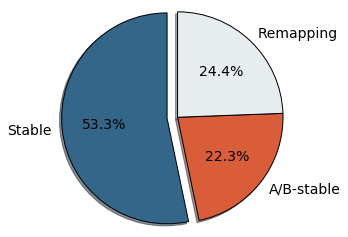

In [54]:
labels = 'Stable', 'A/B-stable', 'Remapping'
sizes = [len(idxs_both_match), len(idxs_only_one), len(idxs_full_remap)]
colors = [color_a, color_b, color_e]
explode = (0.1, 0, 0)

fig = figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
wedges, labels, autopct = ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14}, shadow=True, startangle=90)
ax1.axis('equal')
for lab in labels:
    lab.set_fontsize(14)


#fig.tight_layout()
filename = "stable_remapping_pie_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Mean firing rate for light and dark

In [32]:
# many sessions detected above
sessions = list(sessions_list)

# or a single session
#sessions = [['003282', '2019-11-21_09-44-05']]

total = len(sessions)
stats = {}

for scnt, session_pair in enumerate(sessions):
    animal_id = session_pair[0]
    session_id = session_pair[1]
    h5file = os.path.join(source, animal_id, session_id, 'all.h5')
    
    f = h5py.File(h5file, 'r')

    # get positions
    trajectory = np.array(f['animal_trajectory'])
    arena_trajectory = np.array(f['arena_trajectory'])
    
    units_group = f['units']
    unit_names = [name for name in units_group]

    session_stats = {}
    for unit_group_name in unit_names:
        unit_group = f['units'][unit_group_name]
        
        unit_stats = {}
        
        unit_stats['idxs'] = np.array(unit_group['trajectory_indexes'])
        unit_stats['mfr'] = unit_group.attrs['mean_firing_rate'][0]
        unit_stats['iso'] = unit_group.attrs['isolation_distance'][0]
        unit_stats['sicA'] = unit_group['A_place_field'].attrs['information_content'][0]
        unit_stats['sicB'] = unit_group['B_place_field'].attrs['information_content'][0]
        unit_stats['sicAd'] = unit_group['Ad_place_field'].attrs['information_content'][0]
        unit_stats['sicBd'] = unit_group['Bd_place_field'].attrs['information_content'][0]
        unit_stats['spaA'] = unit_group['A_place_field'].attrs['sparsity']
        unit_stats['spaB'] = unit_group['B_place_field'].attrs['sparsity']
        unit_stats['spaAd'] = unit_group['Ad_place_field'].attrs['sparsity']
        unit_stats['spaBd'] = unit_group['Bd_place_field'].attrs['sparsity']
        
        if 'A_fields_COMs' in unit_group:
            unit_stats['pfrA'] = np.max(np.array(unit_group['A_fields_COMs'])[:, 3])
        if 'B_fields_COMs' in unit_group:
            unit_stats['pfrB'] = np.max(np.array(unit_group['B_fields_COMs'])[:, 3])
        
        session_stats[unit_group_name] = unit_stats
        
    stats[session_id] = {
        'animal': animal_id,
        'traj': trajectory,
        'stats': session_stats
    }
    
    f.close()    

In [33]:
def mean_firing_rate(spiketrain):
    if len(spiketrain) < 5:
        return 0
    mean_ISI = np.mean(np.diff(spiketrain))
    return sampling_rate / mean_ISI

sampling_rate = 30000
mean_FRs = {}

for session_id, data in stats.items():
    trajectory = data['traj']
    s_stats = data['stats']
    
    mean_FRs_for_unit = {}
    for unit_name, unit_stats in s_stats.items():
        if unit_stats['iso'] < 15 or unit_stats['sicA'] < 0.2 or unit_stats['sicB'] < 0.2:
            continue

        if not 'pfrA' in unit_stats or not 'pfrB' in unit_stats:
            continue

        if not unit_stats['pfrA'] > 2 or not unit_stats['pfrB'] > 2:
            continue

        light_idxs = np.where(trajectory[:, 0] - trajectory[0][0] < 960)[0]
        dark_idxs = np.where(trajectory[:, 0] - trajectory[0][0] > 960)[0]

        spiketrain_l = np.intersect1d(light_idxs, unit_stats['idxs'])
        spiketrain_d = np.intersect1d(dark_idxs, unit_stats['idxs'])

        mean_FRs_for_unit[unit_name] = {
            'animal': data['animal'],
            'light': mean_firing_rate(trajectory[spiketrain_l][:, 7]),
            'dark': mean_firing_rate(trajectory[spiketrain_d][:, 7]),
            'spiketrain_l': spiketrain_l,
            'spiketrain_d': spiketrain_d,
            'spa_l': (unit_stats['spaA'] +  unit_stats['spaB'])/2,
            'spa_d': (unit_stats['spaAd'] +  unit_stats['spaBd'])/2,
            'sic_l': (unit_stats['sicA'] +  unit_stats['sicB'])/2,
            'sic_d': (unit_stats['sicAd'] +  unit_stats['sicBd'])/2,
            'traj': trajectory
        }

    mean_FRs[session_id] = mean_FRs_for_unit
    

mean_FR_matrix = []
mean_FR_matrix_refs = []
sic_matrix = []
spa_matrix = []

mean_FR_matrix_matches = []
mean_FR_matrix_no_matches = []
# filt_match = [(data_full_l[i][1], data_full_l[i][2], data_full_l[i][3]) for i in both_match]
# filt_no_match = [(data_full_l[i][1], data_full_l[i][2], data_full_l[i][3]) for i in full_remap]
filt_match = [(data_full_l[i][1], data_full_l[i][2], data_full_l[i][3]) for i in idxs_bm]


for session_id, data in mean_FRs.items():
    for unit_name, unit_FRs in data.items():
        if abs(unit_FRs['light'] - unit_FRs['dark']) < 5:  # filter some bad units, like 5_4 in  2019-11-29_14-16-57
            mean_FR_matrix.append([unit_FRs['light'], unit_FRs['dark']])
            sic_matrix.append([unit_FRs['sic_l'], unit_FRs['sic_d']])
            spa_matrix.append([unit_FRs['spa_l'], unit_FRs['spa_d']])
            
            electrode = unit_name.split('_')[0]
            unit = unit_name.split('_')[1]
            mean_FR_matrix_refs.append([unit_FRs['animal'], session_id, electrode, unit])
            
            #if not (session_id, int(electrode), int(unit)) in filt_match:
            #    mean_FR_matrix_no_matches.append([unit_FRs['light'], unit_FRs['dark']])
            
            if (session_id, int(electrode), int(unit)) in filt_match:
                mean_FR_matrix_matches.append([unit_FRs['light'], unit_FRs['dark']])

            if not (session_id, int(electrode), int(unit)) in filt_match:
                mean_FR_matrix_no_matches.append([unit_FRs['light'], unit_FRs['dark']])

            
#             if (unit_FRs['sic_d'] - unit_FRs['sic_l'])/(unit_FRs['sic_d'] + unit_FRs['sic_l']) > 0.3:
#                 print(session_id, unit_name)
        
        
mean_FR_matrix = np.array(mean_FR_matrix)
sic_matrix = np.array(sic_matrix)
spa_matrix = np.array(spa_matrix)
mean_FR_matrix_matches = np.array(mean_FR_matrix_matches)
mean_FR_matrix_no_matches = np.array(mean_FR_matrix_no_matches)

In [34]:
len(mean_FR_matrix), len(mean_FR_matrix_matches), len(mean_FR_matrix_no_matches)

(147, 98, 49)

## Change in MFR, SPA Light / Dark - some remapping happening?

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


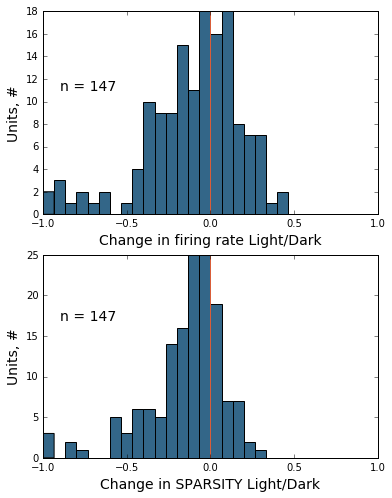

In [35]:
fig = figure(figsize=(6, 8))

border = 0.32
bins = 30

# just diff NO
delta1 = np.diff(mean_FR_matrix, axis=1)

# diff / before NO
delta2 = np.diff(mean_FR_matrix, axis=1).T[0] / mean_FR_matrix[:, 0]

# diff / sum
delta_mfr = np.diff(mean_FR_matrix, axis=1).T[0] / (mean_FR_matrix[:, 0] + mean_FR_matrix[:, 1])

delta_mfr_ma = np.diff(mean_FR_matrix_matches, axis=1).T[0] / (mean_FR_matrix_matches[:, 0] + mean_FR_matrix_matches[:, 1])
delta_mfr_nm = np.diff(mean_FR_matrix_no_matches, axis=1).T[0] / (mean_FR_matrix_no_matches[:, 0] + mean_FR_matrix_no_matches[:, 1])

# log(diff / sum)
delta_mfr_log = np.array([np.log(x) if x > 0 else -np.log(-x) for x in (delta_mfr + 1)])

# SIC / SPA diff / sum
delta_sic = np.diff(sic_matrix, axis=1).T[0] / (sic_matrix[:, 0] + sic_matrix[:, 1])
delta_spa = np.diff(spa_matrix, axis=1).T[0] / (spa_matrix[:, 0] + spa_matrix[:, 1])


ax = fig.add_subplot(211)
ax.set_xlim(-1, 1)
ax.set_xlabel('Change in firing rate Light/Dark', fontsize=14)
ax.set_ylabel('Units, #', fontsize=14)
ax.axvline(0, color=color_b)
a1 = ax.hist(delta_mfr, bins, range=(-1, 1), color=color_a)
ax.text(-0.9, 11, 'n = %d' % len(delta_mfr), fontsize=14)


ax = fig.add_subplot(212)
ax.set_xlim(-1, 1)
ax.set_xlabel('Change in SPARSITY Light/Dark', fontsize=14)
ax.set_ylabel('Units, #', fontsize=14)
ax.axvline(0, color=color_b)
a1 = ax.hist(delta_spa, bins, range=(-1, 1), color=color_a)
ax.text(-0.9, 17, 'n = %d' % len(delta_mfr), fontsize=14)


filename = "change_in_mfr_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

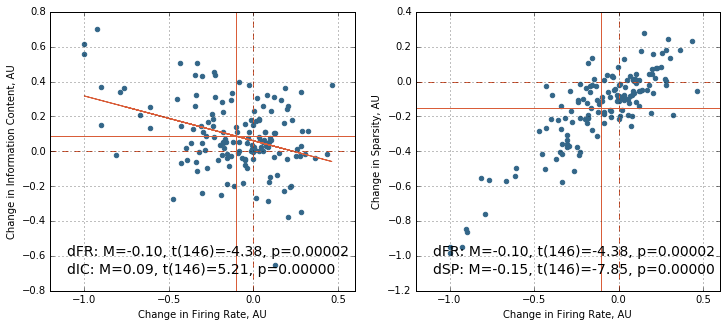

In [36]:
from scipy import stats

fig = figure(figsize=(12, 5))

slope, intercept, r_value, p_value, std_err = stats.linregress(delta_mfr, delta_sic)
t_stat_mfr, p_t_test_mfr = stats.ttest_1samp(delta_mfr, 0.0)
t_stat_sic, p_t_test_sic = stats.ttest_1samp(delta_sic, 0.0)


# ------- delta firing rate - delta information content ----------

ax = fig.add_subplot(121)
ax.scatter(delta_mfr, delta_sic, color=color_a)
ax.plot(delta_mfr, intercept + slope*delta_mfr, color=color_b)
ax.grid()
ax.set_xlabel('Change in Firing Rate, AU')
ax.set_ylabel('Change in Information Content, AU')
ax.axhline(0, ls='--', color=color_b)
ax.axvline(0, ls='--', color=color_b)
ax.axhline(np.mean(delta_sic), color=color_b)
ax.axvline(np.mean(delta_mfr), color=color_b)
ax.text(-1.1, -0.6, 'dFR: M=%.2f, t(%d)=%.2f, p=%.5f' % (np.mean(delta_mfr), len(delta_mfr) - 1, t_stat_mfr, p_t_test_mfr), fontsize=14)
ax.text(-1.1, -0.7, 'dIC: M=%.2f, t(%d)=%.2f, p=%.5f' % (np.mean(delta_sic), len(delta_sic) - 1, t_stat_sic, p_t_test_sic), fontsize=14)


# ------- delta firing rate - delta sparsity ----------

slope, intercept, r_value, p_value, std_err = stats.linregress(delta_mfr, delta_sic)
t_stat_mfr, p_t_test_mfr = stats.ttest_1samp(delta_mfr, 0.0)
t_stat_spa, p_t_test_spa = stats.ttest_1samp(delta_spa, 0.0)

ax = fig.add_subplot(122)
ax.scatter(delta_mfr, delta_spa, color=color_a)
ax.grid()
ax.set_xlabel('Change in Firing Rate, AU')
ax.set_ylabel('Change in Sparsity, AU')
ax.axhline(0, ls='--', color=color_b)
ax.axvline(0, ls='--', color=color_b)
ax.axhline(np.mean(delta_spa), color=color_b)
ax.axvline(np.mean(delta_mfr), color=color_b)
ax.text(-1.1, -1., 'dFR: M=%.2f, t(%d)=%.2f, p=%.5f' % (np.mean(delta_mfr), len(delta_mfr) - 1, t_stat_mfr, p_t_test_mfr), fontsize=14)
ax.text(-1.1, -1.1, 'dSP: M=%.2f, t(%d)=%.2f, p=%.5f' % (np.mean(delta_spa), len(delta_spa) - 1, t_stat_spa, p_t_test_spa), fontsize=14)



filename = "change_in_mfr_spa_sic_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Non-matches (fields that loose their match when dark) vs Position in the Arena. What does this mean?!


Non-matches - should basically be the "visual" ones
Matches - should be the ones that have PI input

So here - matches are everywhere, can be
non-matches are mostly visuals (0.3) in the middle

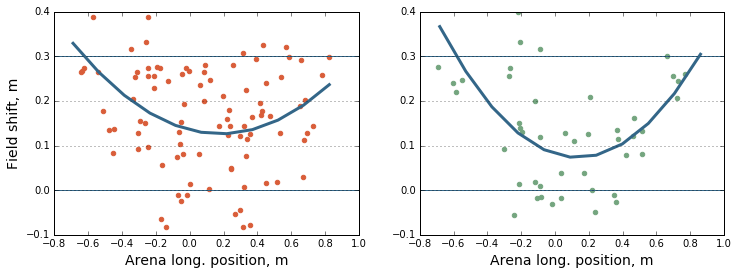

In [37]:
fig = figure(figsize=(12, 4))

# ------- in light distribution ---------

ax = fig.add_subplot(121)
ax.set_ylim(-0.1, 0.4)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('Field shift, m', fontsize=14)
ax.scatter(data_l[idxs_bm][:, 15], data_l[idxs_bm][:, 6], color=color_b)
ax.axhline(0.3, color=color_a)
ax.axhline(0.0, color=color_a)
ax.yaxis.grid(True)

b_x = np.array(data_l[idxs_bm][:, 15], dtype=float)
b_y = np.array(data_l[idxs_bm][:, 6], dtype=float)
a, b, c = np.polyfit(b_x, b_y, 2)
y_min = data_l[idxs_l][:, 15].min()
y_max = data_l[idxs_l][:, 15].max()
x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]
ax.plot(x_space, y_space, linewidth=3, color=color_a)

# ------- in dark distribution ---------

ax = fig.add_subplot(122)
ax.set_ylim(-0.1, 0.4)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.scatter(data_l[idxs_nm][:, 15], data_l[idxs_nm][:, 6], color=color_c)
ax.axhline(0.3, color=color_a)
ax.axhline(0.0, color=color_a)
ax.yaxis.grid(True)

b_x = np.array(data_l[idxs_nm][:, 15], dtype=float)
b_y = np.array(data_l[idxs_nm][:, 6], dtype=float)
a, b, c = np.polyfit(b_x, b_y, 2)
y_min = data_d[idxs_d][:, 15].min()
y_max = data_d[idxs_d][:, 15].max()
x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]
ax.plot(x_space, y_space, linewidth=3, color=color_a)


filename = "field_arena_distribution_STABLE_UNSTABLE.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

In [38]:
delta_mfr_ma = np.diff(mean_FR_matrix_matches, axis=1).T[0] / (mean_FR_matrix_matches[:, 0] + mean_FR_matrix_matches[:, 1])
delta_mfr_nm = np.diff(mean_FR_matrix_no_matches, axis=1).T[0] / (mean_FR_matrix_no_matches[:, 0] + mean_FR_matrix_no_matches[:, 1])

## Integrators  of 


- stable (don not rely on vision by definition, but can include vision - look at delta FR): 
    - around 0.3: tactile, lock to boundaries (ARENA RF)
    - 0.0 - 0.15: Driven by vestibular + proprioception (fully idiothetical)
        - 0: (ROOM RF) non-visual (as it continues to fire), good V+P integration!
        - ~0.15 (? RF) joint Vis+V+P? test this group for COM shift in dark / Light

- dark unstable: more visual, with little path integration influence. usually go silent (fully visual) or remap
    - around 0: visual. Go silent or remap
    - around ~0.15 visual. Go silent or remap, little shift tells potential V+P input
    - around 0.3

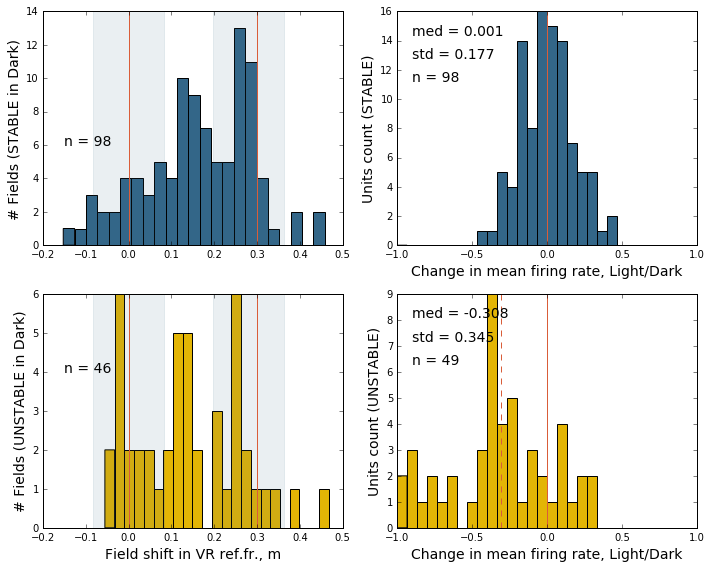

In [49]:
fig = figure(figsize=(10, 8))

bins_fs = 23
bins_fr = 30

SD = 0.082


ax = fig.add_subplot(221)
ax.set_xlim(-0.2, 0.5)
ax.set_ylabel('# Fields (STABLE in Dark)', fontsize=14)
ax.hist(data_l[idxs_bm][:, 6], bins_fs, color=color_a)  # interesting 3-modal distribution? 
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
#ax.axvline(np.median(data_l[idxs_bm][:, 6]), color=color_b, lw=3)
ax.text(-0.15, 6, 'n = %d' % len(data_l[idxs_bm]), fontsize=14)
ax.axvspan(-SD, SD, alpha=0.1, color=color_a)
#ax.axvspan(0.11, 0.19, alpha=0.1, color=color_a)
ax.axvspan(0.28 - SD, 0.28 + SD, alpha=0.1, color=color_a)



data = delta_mfr_ma
med = np.median(data)
std = np.std(data)

ax = fig.add_subplot(222)
ax.set_xlim(-1, 1)
ax.set_xlabel('Change in mean firing rate, Light/Dark', fontsize=14)
ax.set_ylabel('Units count (STABLE)', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(med, ls='--', color=color_b)
a1 = ax.hist(delta_mfr_ma, bins_fr, range=(-1, 1), color=color_a)
ax.text(-0.9, 0.9 * a1[0].max(), 'med = %.3f' % med, fontsize=14)
ax.text(-0.9, 0.8 * a1[0].max(), 'std = %.3f' % std, fontsize=14)
ax.text(-0.9, 0.7 * a1[0].max(), 'n = %d' % len(data), fontsize=14)


ax = fig.add_subplot(223)
ax.set_xlim(-0.2, 0.5)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('# Fields (UNSTABLE in Dark)', fontsize=14)
ax.hist(data_l[idxs_nm][:, 6], bins_fs, color=color_d)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
#ax.axvline(np.median(data_l[idxs_nm][:, 6]), color=color_b, lw=3)
ax.text(-0.15, 4, 'n = %d' % len(data_l[idxs_nm]), fontsize=14)
ax.axvspan(-SD, SD, alpha=0.1, color=color_a)
#ax.axvspan(0.11, 0.19, alpha=0.1, color=color_a)
ax.axvspan(0.28 - SD, 0.28 + SD, alpha=0.1, color=color_a)



data = delta_mfr_nm
med = np.median(data)
std = np.std(data)

ax = fig.add_subplot(224)
ax.set_xlim(-1, 1)
ax.set_xlabel('Change in mean firing rate, Light/Dark', fontsize=14)
ax.set_ylabel('Units count (UNSTABLE)', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(med, ls='--', color=color_b)
a1 = ax.hist(delta_mfr_nm, bins_fr, range=(-1, 1), color=color_d)
ax.text(-0.9, 0.9 * a1[0].max(), 'med = %.3f' % med, fontsize=14)
ax.text(-0.9, 0.8 * a1[0].max(), 'std = %.3f' % std, fontsize=14)
ax.text(-0.9, 0.7 * a1[0].max(), 'n = %d' % len(data), fontsize=14)

fig.tight_layout()
filename = "shift_stable_vs_unstable_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Normalized STABLE vs UNSTABLE

In [53]:
from scipy.signal import savgol_filter

SD = 0.082

hist_st, edges_st = np.histogram(data_l[idxs_bm][:, 6], bins=21, range=(-0.2, 0.5))
hist_un, edges_un = np.histogram(data_l[idxs_nm][:, 6], bins=21, range=(-0.2, 0.5))

a = savgol_filter(hist_st/hist_st.sum(), 9, 3)
b = savgol_filter(hist_un/hist_un.sum(), 9, 3)

fig = figure(figsize=(5, 4))

ax = fig.add_subplot(111)
ax.plot(edges_st[:-1], a, ls='--', linewidth=2, alpha=0.9, color=color_a)
ax.plot(edges_un[:-1], b, ls='--', linewidth=2, alpha=0.9, color=color_d)
ax.plot(edges_st[:-1], a - b, linewidth=2, color=color_b)
ax.axhline(0, color=color_b)
ax.axvline(0, color=color_b)
ax.axvline(0.28, color=color_b)
ax.axvspan(-SD, SD, alpha=0.1, color=color_a)
ax.axvspan(0.28 - SD, 0.28 + SD, alpha=0.1, color=color_a)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('STABLE vs UNSTABLE, #, Norm.', fontsize=14)

fig.tight_layout()
filename = "shift_stable_vs_unstable_dark_NORM_DELTA.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

# normalized to the original light distribution (144)

## conclusion: stable cells require path integrator input, unstable - do not get path integrator input

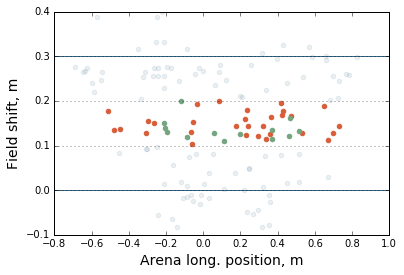

In [51]:
# take cells that are stable in dark (matching) having ~0.1 - 0.2 shift
all_low_shift = np.where( (data_l[:, 6] > 0.1) & (data_l[:, 6] < 0.2) )[0]
stable_low_shift = np.intersect1d(idxs_bm, all_low_shift)
unstable_low_shift = np.intersect1d(idxs_nm, all_low_shift)

fig = figure(figsize=(6, 4))

# ------- stable low shift arena distribution ---------

ax = fig.add_subplot(111)
ax.set_ylim(-0.1, 0.4)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('Field shift, m', fontsize=14)
ax.scatter(data_l[idxs_l][:, 15], data_l[idxs_l][:, 6], alpha=0.1, color=color_a)
ax.scatter(data_l[stable_low_shift][:, 15], data_l[stable_low_shift][:, 6], color=color_b)
ax.scatter(data_l[unstable_low_shift][:, 15], data_l[unstable_low_shift][:, 6], color=color_c)

ax.axhline(0.3, color=color_a)
ax.axhline(0.0, color=color_a)
ax.yaxis.grid(True)

# Idiothetic-driven fields get more error in dark

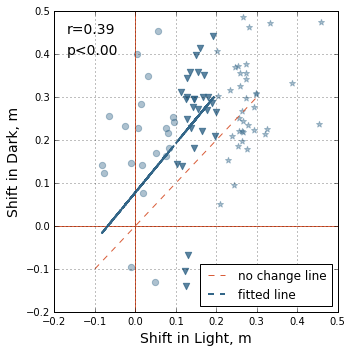

In [62]:
all_0_shift =   np.where( (data_l[:, 6] > -0.1) & (data_l[:, 6] < 0.1) )[0]
all_low_shift = np.where( (data_l[:, 6] > 0.1) & (data_l[:, 6] < 0.2) )[0]
all_30_shift =  np.where( (data_l[:, 6] > 0.2) )[0]

stable_0_shift = np.intersect1d(idxs_bm, all_0_shift)
stable_low_shift = np.intersect1d(idxs_bm, all_low_shift)
stable_30_shift = np.intersect1d(idxs_bm, all_30_shift)


fig = figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.grid()
ax.set_xlim(-0.2, 0.5)
ax.set_ylim(-0.2, 0.5)
ax.set_xlabel('Shift in Light, m', fontsize=14)
ax.set_ylabel('Shift in Dark, m', fontsize=14)
ax.axhline(0, color=color_b)
ax.axvline(0, color=color_b)

# ------------ compute fitting ------------
COM_data = []
for i in np.concatenate([stable_0_shift, stable_low_shift]):
    match_Al_to_Ad = field_matches[i][0]
    match_Bl_to_Bd = field_matches[i][1]

    COM_shift_l = match_Bl_to_Bd[3][0] - match_Al_to_Ad[3][0]
    COM_shift_d = match_Bl_to_Bd[3][1] - match_Al_to_Ad[3][1]

    COM_data.append([COM_shift_l, COM_shift_d])
    
COM_data = np.array(COM_data)
slope, intercept, r_value, p_value, std_err = scipystats.linregress(COM_data[:, 0], COM_data[:, 1])

# ------ plot groups ----------------
clrs = [color_d, color_b, color_a]
alphas = [0.4, 0.8, 0.4]
markers = ('o', 'v', '*')
for j, group_idx_array in enumerate([stable_0_shift, stable_low_shift, stable_30_shift]):
    to_plot = []
    for i in group_idx_array:
        match_Al_to_Ad = field_matches[i][0]
        match_Bl_to_Bd = field_matches[i][1]

        COM_shift_l = match_Bl_to_Bd[3][0] - match_Al_to_Ad[3][0]
        COM_shift_d = match_Bl_to_Bd[3][1] - match_Al_to_Ad[3][1]

        to_plot.append([COM_shift_l, COM_shift_d])

    to_plot = np.array(to_plot)
    ax.scatter(to_plot[:, 0], to_plot[:, 1], s=40, marker=markers[j], color=color_a, alpha=alphas[j])


# no change line
line = np.linspace(-0.1, 0.3, 10)
ax.plot(line, line, color=color_b, ls='--', label='no change line')

# fitted line
ax.plot(COM_data[:, 0], intercept + slope*COM_data[:, 0], ls='--', lw=2, color=color_a, label='fitted line')
ax.legend(loc='lower right')

ax.text(-0.17, 0.45, 'r=%.2f' % r_value, fontsize=14)
ax.text(-0.17, 0.4, 'p<%.2f' % p_value, fontsize=14)

fig.tight_layout()
filename = "shift_increase_in_dark.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

In [ ]:
# should we include other experiment type to here?
# BOTH - no visual cells. doesn't make sense
# VISUAL - ? maybe for change in firing rate? or for dark too? Need to think about it
# 

# Direction of field shift between the same fields in light / dark

considering only MATCHES (as we need all 4 fields) and 0.15 as a group of interest
- shift of Al - Ad
- shift of Bl - Bd
- scatter of Al - Ad vs Bl - Bd (should be in one of the quarters)

In [ ]:
"""
field_matches = [
    [ 
        # match_Al_to_Ad
        [field_Al_id, field_Ad_id, intersection_rel, [field_Al_COM_y, field_Ad_COM_y]], 
        
        # match_Bl_to_Bd
        [field_Bl_id, field_Bd_id, intersection_rel, [field_Bl_COM_y, field_Bd_COM_y]]
    ],
    ...
]
"""

data_all = []
for j, group_idx_array in enumerate([stable_low_shift, stable_30_shift]):
    to_plot = []
    for i in group_idx_array:
        match_Al_to_Ad = field_matches[i][0]
        match_Bl_to_Bd = field_matches[i][1]

        COM_shift_A = match_Al_to_Ad[3][0] - match_Al_to_Ad[3][1]  # should be positive
        COM_shift_B = match_Bl_to_Bd[3][1] - match_Bl_to_Bd[3][0]  # should be negative

        to_plot.append([COM_shift_A, COM_shift_B])

    data_all.append(np.array(to_plot))
    
fig = figure(figsize=(10, 5))

lim = 0.3

to_plot = data_all[0]
ax = fig.add_subplot(121)
ax.grid()
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_a)
ax.axhline(0, color=color_b)
ax.axvline(0, color=color_b)
ax.axvline(np.median(to_plot[:, 0]), ls='--', color=color_b)
ax.axhline(np.median(to_plot[:, 1]), ls='--', color=color_b)
ax.set_title("Field SHIFT towards the MIDDLE\nb/w conditions: GROUP 0.15", fontsize=14)
ax.set_xlabel('A: Light vs Dark, m', fontsize=14)
ax.set_ylabel('B: Light vs Dark, m', fontsize=14)


to_plot = data_all[1]
ax = fig.add_subplot(122)
ax.grid()
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_a)
ax.axhline(0, color=color_b)
ax.axvline(0, color=color_b)
ax.axvline(np.median(to_plot[:, 0]), ls='--', color=color_b)
ax.axhline(np.median(to_plot[:, 1]), ls='--', color=color_b)
ax.set_title("Field SHIFT towards the MIDDLE\nb/w conditions: GROUP 0.3", fontsize=14)
ax.set_xlabel('A: Light vs Dark, m', fontsize=14)
#ax.set_ylabel('B: Light vs Dark, m', fontsize=14)


fig.tight_layout()
filename = "vSHIFT_dark_shift_towards_middle.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Spike raster plot light / dark

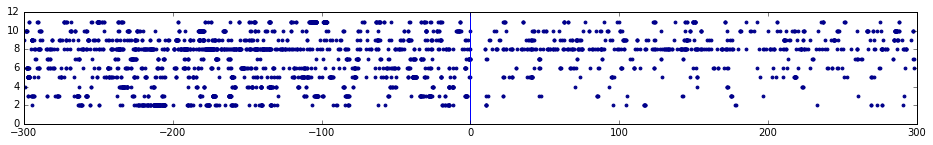

In [61]:
# -------- assembling data ------------------

period = 300
trajs = []
spiketrains_l = []
spiketrains_d = []
mfrs_l = []
mfrs_d = []

for session_id, data in mean_FRs.items():
    for unit_name, unit_FRs in data.items():
        spiketrains_l.append(unit_FRs['spiketrain_l'])
        spiketrains_d.append(unit_FRs['spiketrain_d'])
        trajs.append(unit_FRs['traj'])
        mfrs_l.append(unit_FRs['light'])
        mfrs_d.append(unit_FRs['dark'])

# -------- sorting ------------------

rank = []
for i, st in enumerate(spiketrains_l):
    lA = mfrs_l[i]
    lB = mfrs_d[i]
    
    #traj = trajs[i]
    #last_50 = np.where(traj[:, 0] - traj[0][0] > 960 - period)[0]
    #first_50 = np.where(traj[:, 0] - traj[0][0] < 960 + period)[0]
    #lA = len( np.intersect1d(last_50, spiketrains_l[i]) )
    #lB = len( np.intersect1d(first_50, spiketrains_d[i]) )

    rank_i = (lB - lA)/(lA + lB) if (lA + lB) > 0 else 10000
    rank.append(rank_i)

index = np.argsort(np.array(rank))

# ---------- spike raster plot ----------

fig = figure(figsize=(16, 2))

ax = fig.add_subplot(111)

cnt = 0
for pos, i in enumerate([int(x) for x in index]):
    if rank[i] > -0.4:
        continue
    
    # light periods
    traj = trajs[i]
    duration = traj[-1][0] - traj[0][0]
    
    last_50 = np.where(traj[:, 0] - traj[0][0] > 960 - period)[0]
    res_idxs = np.intersect1d(last_50, spiketrains_l[i])
   
    times = traj[res_idxs][:, 0] - traj[0][0] - 960
    values = np.zeros(len(times)) + cnt + 1 # + len(spiketrains_l)
    ax.scatter(times, values, s=8, color='darkblue')

    # dark periods
    first_50 = np.where(traj[:, 0] - traj[0][0] < 960 + period)[0]
    res_idxs = np.intersect1d(first_50, spiketrains_d[i])
   
    times = traj[res_idxs][:, 0] - traj[0][0] - 960 + 10
    values = np.zeros(len(times)) + cnt + 1
    ax.scatter(times, values, s=8, color='darkblue')
    
    cnt += 1

ax.set_ylim(0, cnt + 1)
ax.set_xlim(-period, period)
ax.axvline(0)

In [51]:
len(np.where(np.array(rank) < -0.35)[0])

15

## Cells with lowered mean firing rate are driven by VR + path integration, while stable FR cells split into tactile and path integration units

1. work out lowered FR. include only cells that really dropped down they firing. Plot example groups in small plots separately to visually see the effects

3. Plot arena-locked cells with stable firing relative to the border distance

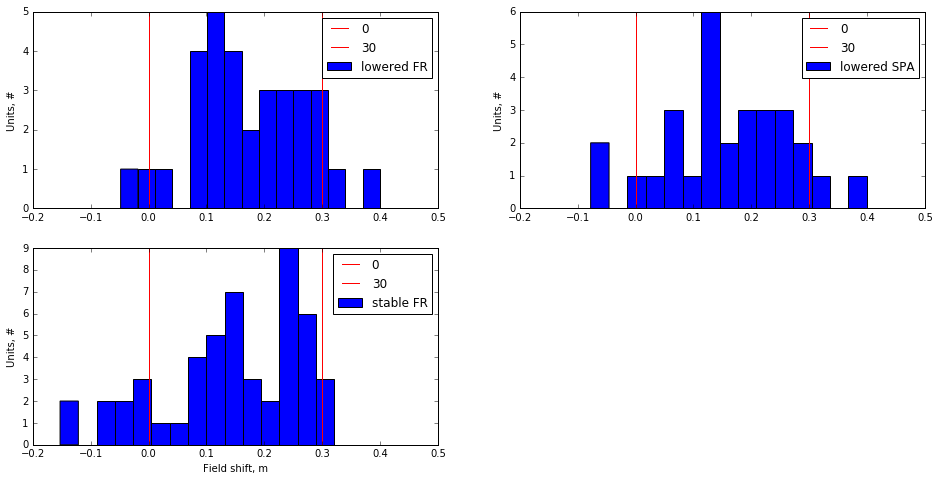

In [24]:
delta_mfr = np.diff(mean_FR_matrix, axis=1).T[0] / (mean_FR_matrix[:, 0] + mean_FR_matrix[:, 1])
delta_sic = np.diff(sic_matrix, axis=1).T[0] / (sic_matrix[:, 0] + sic_matrix[:, 1])
delta_spa = np.diff(spa_matrix, axis=1).T[0] / (spa_matrix[:, 0] + spa_matrix[:, 1])



fig = figure(figsize=(16, 12))
bins = 15
border = 0.2

# ------------ firing rate decreased ----------

idxs_low = np.where((delta_mfr < -border))[0]
units_list = [mean_FR_matrix_refs[i] for i in idxs_low]

# can be more than in idxs_low because of multiple patches
idxs_dec = [i for i, val in enumerate(data_full_l) if [val[0], val[1], str(val[2]), str(val[3])] in units_list]
idxs_results = np.intersect1d(idxs_l, idxs_dec)

ax = fig.add_subplot(321)
ax.set_xlim(-0.2, 0.5)
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
ax.axvline(0.3, color='red')
#ax.axvline(np.median(data_l[idxs_results][:, 6]), color='red')
a1 = ax.hist(data_l[idxs_results][:, 6], bins)
ax.legend(['0', '30', 'lowered FR'])

# ------------ firing rate stable ----------

idxs_low = np.where((delta_mfr > -border) & (delta_mfr < border))[0]
units_list = [mean_FR_matrix_refs[i] for i in idxs_low]

# can be more than in idxs_low because of multiple patches
idxs_dec = [i for i, val in enumerate(data_full_l) if [val[0], val[1], str(val[2]), str(val[3])] in units_list]
idxs_results = np.intersect1d(idxs_l, idxs_dec)

ax = fig.add_subplot(323)
ax.set_xlim(-0.2, 0.5)
ax.set_xlabel('Field shift, m')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
ax.axvline(0.3, color='red')
#ax.axvline(np.median(data_l[idxs_results][:, 6]), color='red')
a2 = ax.hist(data_l[idxs_results][:, 6], bins)
ax.legend(['0', '30', 'stable FR'])

# ------------ sparsity decreased ----------

idxs_low = np.where((delta_spa < -border))[0]
units_list = [mean_FR_matrix_refs[i] for i in idxs_low]

# can be more than in idxs_low because of multiple patches
idxs_dec = [i for i, val in enumerate(data_full_l) if [val[0], val[1], str(val[2]), str(val[3])] in units_list]
idxs_results = np.intersect1d(idxs_l, idxs_dec)

ax = fig.add_subplot(322)
ax.set_xlim(-0.2, 0.5)
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
ax.axvline(0.3, color='red')
#ax.axvline(np.median(data_l[idxs_results][:, 6]), color='red')
a1 = ax.hist(data_l[idxs_results][:, 6], bins)
ax.legend(['0', '30', 'lowered SPA'])

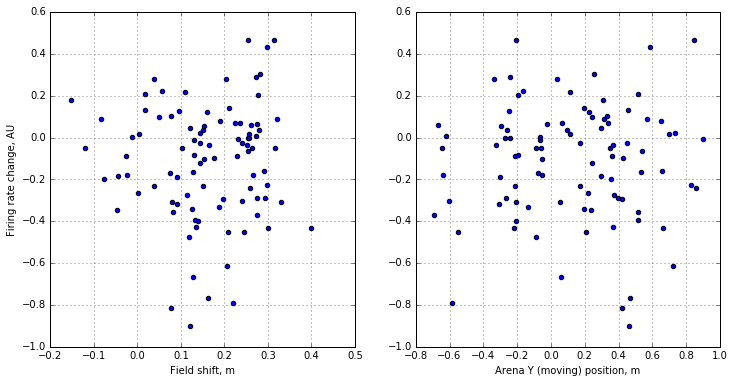

In [178]:
shift_vs_fr = []
posy_vs_frd = []

for i in idxs_l:  # take only light fields?
    val  = data_full_l[i]
    session_id = val[1]
    unit_name = '%d_%d' % (val[2], val[3])
    
    FRl = mean_FRs[session_id][unit_name]['light']
    FRd = mean_FRs[session_id][unit_name]['dark']
    
    delta = (FRd - FRl) / (FRl + FRd)
    
    shift_vs_fr.append([val[8], delta])
    posy_vs_frd.append([val[17], delta])

# ------- NO DEPENDENCY!! -----------------------

shift_vs_fr = np.array(shift_vs_fr)
posy_vs_frd = np.array(posy_vs_frd)
results = scipystats.linregress(shift_vs_fr[:, 0], shift_vs_fr[:, 1])


fig = figure(figsize=(12, 6))

ax = fig.add_subplot(121)
ax.scatter(shift_vs_fr[:, 0], shift_vs_fr[:, 1])
ax.grid()
ax.set_xlabel('Field shift, m')
ax.set_ylabel('Firing rate change, AU')


ax = fig.add_subplot(122)
ax.scatter(posy_vs_frd[:, 0], posy_vs_frd[:, 1])
ax.grid()
ax.set_xlabel('Arena Y (moving) position, m')



In [ ]:
# MFR for selected units: cell firing disappeared in dark



In [59]:
units_test = [['003282', '2019-11-26_09-48-18', '4', '8'],
                ['003281', '2019-11-21_22-51-03', '4', '3']]
idxs_test = [i for i, val in enumerate(data_full_l) if [val[0], val[1], str(val[2]), str(val[3])] in units_test]
data_l[idxs_test]

array([[  4.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   9.06054280e-01,   4.55633803e-02,
         -4.48176015e-02,   4.14462569e-01,   3.82350321e-01,
          1.00000000e+00,   2.00000000e+00,   6.59268010e+00,
          5.75272745e+00,   3.96659708e-02,  -9.32798576e-02,
          2.94477743e-01,  -8.50698503e-02,   2.49660142e-01,
          1.52968323e+01],
       [  4.00000000e+00,   8.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   8.55769231e-01,   4.03949573e-02,
          3.90961160e-02,   5.14056487e-01,   6.59913465e-01,
          1.00000000e+00,   1.00000000e+00,   6.88961979e+00,
          5.94041340e+00,   9.61538462e-03,  -2.06795893e-01,
          1.73064226e-01,  -2.16956911e-01,   2.12160342e-01,
          3.64237717e+01]])

## Print sessions with interesting units

In [23]:
strangers = np.where((data_d[:, 6] < 0.1))[0]
idxs_filt = reduce(np.intersect1d, [idxs_ic_d, idxs_fr_d, idxs_id_d, strangers])

for i in idxs_filt:
    print(data_full_d[i][0], data_full_d[i][1], data_full_d[i][2], data_full_d[i][3], data_full_d[i][8])


PF match found for 197 fields, 170 fields remapped
003282 2019-11-29_14-16-57 6 4 -0.10396560174195263
003282 2019-11-20_15-58-39 7 3 -0.06861923760742751
003282 2019-11-20_15-58-39 7 8 -0.09582743532716421
003281 2019-11-21_13-44-47 4 3 -0.0030589222933772864
003281 2019-11-21_13-44-47 4 5 0.051474992837111266


In [113]:
dest_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/dark_unstable_0_shift'
source_folder = str(source)

# diffs = np.diff(mean_FR_matrix, axis=1).T[0] / (mean_FR_matrix[:, 0] + mean_FR_matrix[:, 1])
# idxs = np.where((diffs < -0.3))[0]

all_0_shift = np.where( (data_l[:, 6] > -0.1) & (data_l[:, 6] < 0.1) )[0]
unstable_0_shift = np.intersect1d(idxs_nm, all_0_shift)


units_list = []
for i in unstable_0_shift:
    units_list.append([
        data_full_l[i][0], data_full_l[i][1], data_full_l[i][2], data_full_l[i][3]
    ])

units_list

create_symlinks(dest_folder, source_folder, units_list, prefix='D_')